In [287]:
!nvidia-smi

Wed Nov  1 18:28:02 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.68                 Driver Version: 531.68       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1650 Ti    WDDM | 00000000:01:00.0 Off |                  N/A |
| N/A   51C    P8                4W /  N/A|    930MiB /  4096MiB |     33%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [288]:
# %pip install -qqqU wandb transformers lightning albumentations torchmetrics torchinfo
# %pip install -qqq requests gradio

In [289]:
# %pip install opencv-python
# %pip install numpy
# %pip install matplotlib

In [290]:
import os
import zipfile
import platform
import warnings
from glob import glob
from dataclasses import dataclass

In [291]:
import cv2 as cv 
import requests
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

from transformers import SegformerForSemanticSegmentation

import lightning.pytorch as pl
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint

from torchmetrics import MeanMetric
from torchmetrics.classification import MulticlassF1Score

from torchinfo import summary

In [292]:
torch.set_float32_matmul_precision('high')

os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"

%matplotlib inline

In [293]:
import wandb

wandb.login()

True

In [294]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES: int = 4
    IMAGE_SIZE: tuple[int,int] = (288, 288)
    MEAN:tuple = (0.485, 0.456, 0.406)
    STD: tuple = (0.229, 0.224, 0.225)
    URL: str = r"https://www.dropbox.com/scl/fi/r0685arupp33sy31qhros/dataset_UWM_GI_Tract_train_valid.zip?rlkey=w4ga9ysfiuz8vqbbywk0rdnjw&dl=1"
    DATASET_PATH: str = r"C:\Users\ANING\OneDrive\Documents\python\dataset_UWM_GI_Tract_train_valid"
    

In [295]:
class DatasetSegmentation(Dataset):
    def __init__(self,is_training,mean,std,img_size,images,masks):
        self.img_size = img_size
        self.images = images
        self.masks = masks
        self.mean = mean
        self.std = std
        self.is_training = is_training
        self.transforms = self.transformations(self.mean,self.std)
        pass

    def __len__(self):
        return len(self.images)

    def load_images(self,image,depth= 0):
        image = cv.imread(image,depth)
        if depth == cv.IMREAD_COLOR:
            cv.cvtColor(image,cv.COLOR_BGR2RGB)
        else:
            pass
        return cv.resize(image,self.img_size,interpolation=cv.INTER_NEAREST)

    def transformations(self,mean,std):
        transforms = []

        if self.is_training ==True:
            transforms.extend([
                A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5),
                A.ShiftScaleRotate(scale_limit=0.12, rotate_limit=0.15, shift_limit=0.12, p=0.5),
                A.RandomBrightnessContrast(p=0.5),
                A.CoarseDropout(max_holes=8, max_height=self.img_size[1]//20, max_width=self.img_size[0]//20, min_holes=5, fill_value=0, mask_fill_value=0, p=0.5)
            ])
        
        else:
            transforms.extend([
                A.Normalize(mean=mean, std=std, always_apply=True),
                ToTensorV2(always_apply=True),  # (H, W, C) --> (C, H, W)
            ])

        return A.Compose(transforms)
    
    def __getitem__(self, index):
        image = self.load_images(self.images[index],depth=cv.IMREAD_COLOR)
        mask = self.load_images(self.masks[index],depth=cv.IMREAD_GRAYSCALE)
        transformed = self.transforms(image = image,mask = mask)
        image,mask = transformed['image'] , transformed['mask'].to(torch.long)
        return image,mask


    


        

In [311]:

class SegmentationDataset(pl.LightningDataModule):
    def __init__(self,num_classes=7,img_size=(288, 288),ds_mean=(0.485, 0.456, 0.406),ds_std=(0.229, 0.224, 0.225),batch_size=32,num_workers=0, pin_memory=False,shuffle_validation=False,) :

        super().__init__()
        self.num_classes = num_classes
        self.mean = ds_mean
        self.batch_size = batch_size
        self.std  = ds_std
        self.img_size = img_size
        self.shuffle_validation = shuffle_validation
        self.pin_memory = pin_memory
        self.num_workers = num_workers
      

    def setup(self,*args,**kwargs):
       train_images = sorted(glob(os.path.join(DatasetConfig.DATASET_PATH,'train','images',r'*.png')))
       train_masks = sorted(glob(os.path.join(DatasetConfig.DATASET_PATH,'train','masks',r'*.png')))
       valid_images = sorted(glob(os.path.join(DatasetConfig.DATASET_PATH,'valid','images',r'*.png')))
       valid_masks = sorted(glob(os.path.join(DatasetConfig.DATASET_PATH,'valid','masks',r'*.png')))
       
       self.train_ds = DatasetSegmentation(is_training=True,mean=self.mean,std=self.std,images=train_images[:200],masks=train_masks[:200],img_size=self.img_size)
       self.valid_ds = DatasetSegmentation(is_training=False,mean=self.mean,std=self.std,images=valid_images[:200],masks=valid_masks[:200],img_size=self.img_size)

       
    def train_dataloader(self):
        return DataLoader(self.train_ds,batch_size=self.batch_size,drop_last=True,num_workers=self.num_workers,pin_memory=self.pin_memory,shuffle=True,)
    
    def val_dataloader(self):
        return  DataLoader(self.valid_ds,batch_size=self.batch_size,drop_last=False,num_workers=self.num_workers,shuffle=self.shuffle_validation)

        


       

In [312]:
mmd = SegmentationDataset(
    num_classes=DatasetConfig.NUM_CLASSES,
    img_size=DatasetConfig.IMAGE_SIZE,
    ds_mean=DatasetConfig.MEAN,
    ds_std=DatasetConfig.STD,
    batch_size=32,
    num_workers=0,
    shuffle_validation=True,
)

mmd.setup()

train_batch = mmd.train_dataloader()
valid_batch = mmd.val_dataloader()

In [313]:
index_to_color = {
    0 : (0,0,0),
    1 : (0,0,255),
    2 : (0,255,0),
    3 : (255,0,0),
}

In [314]:
def mask_to_label(msks,color_map):
    mask = np.zeros(msks.shape[:2] + (3,))
    img_mask = np.squeeze(msks)

    for k in color_map.keys():
        mask[k == img_mask] = color_map[k]

    return np.float32(mask)/255

In [315]:
def overlay_mask(image,mask):
    alpha = 1.0
    beta = 0.7
    gamma = 0.0

    mask = cv.cvtColor(mask,cv.COLOR_RGB2BGR)
    image = cv.cvtColor(image,cv.COLOR_RGB2BGR)

    image = cv.addWeighted(image,alpha,mask,beta,gamma)
    image = cv.cvtColor(image,cv.COLOR_BGR2RGB)

    return np.clip(image,0.0,1.0)

In [316]:
def display_image_and_mask(*, images, masks, color_map=index_to_color):
    title = ["GT Image", "Color Mask", "Overlayed Mask"]

    for idx in range(10):
        image = images[idx]
        grayscale_gt_mask = masks[idx]

        fig = plt.figure(figsize=(15, 4))

        # Create RGB segmentation map from grayscale segmentation map.
        rgb_gt_mask = mask_to_label(grayscale_gt_mask, color_map=color_map)

        # Create the overlayed image.
        overlayed_image = overlay_mask(image, rgb_gt_mask)

        plt.subplot(1, 3, 1)
        plt.title(title[0])
        plt.imshow(image)
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.title(title[1])
        plt.imshow(rgb_gt_mask)
        plt.axis("off")

        plt.imshow(rgb_gt_mask)
        plt.subplot(1, 3, 3)
        plt.title(title[2])
        plt.imshow(overlayed_image)
        plt.axis("off")

        plt.tight_layout()
        plt.show()

    return

In [317]:
def denormalize(tensors, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    for c in range(3):
        tensors[:, c, :, :].mul_(std[c]).add_(mean[c])

    return torch.clamp(tensors, min=0.0, max=1.0)

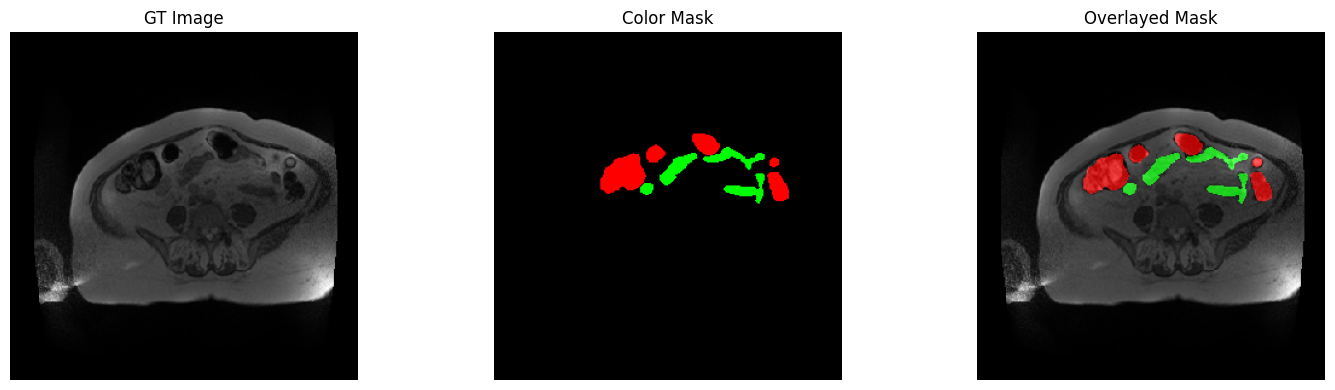

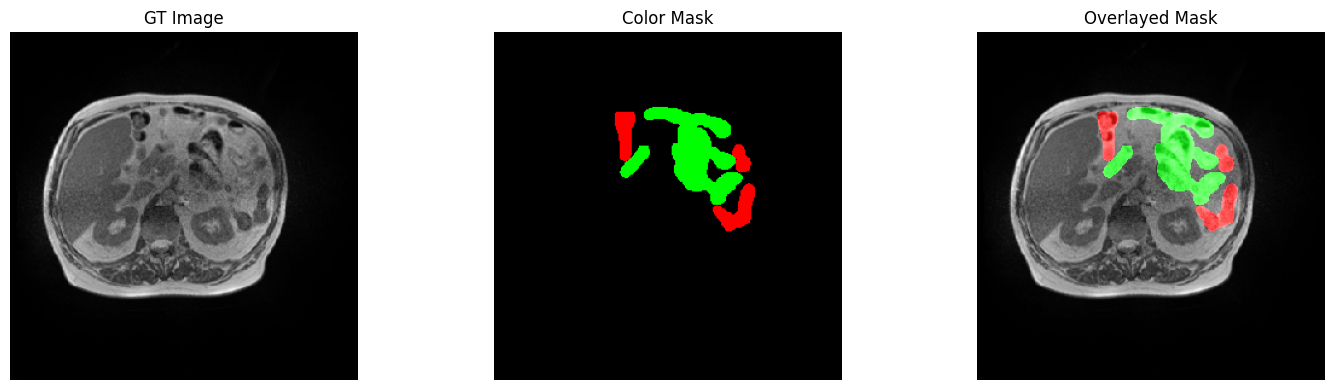

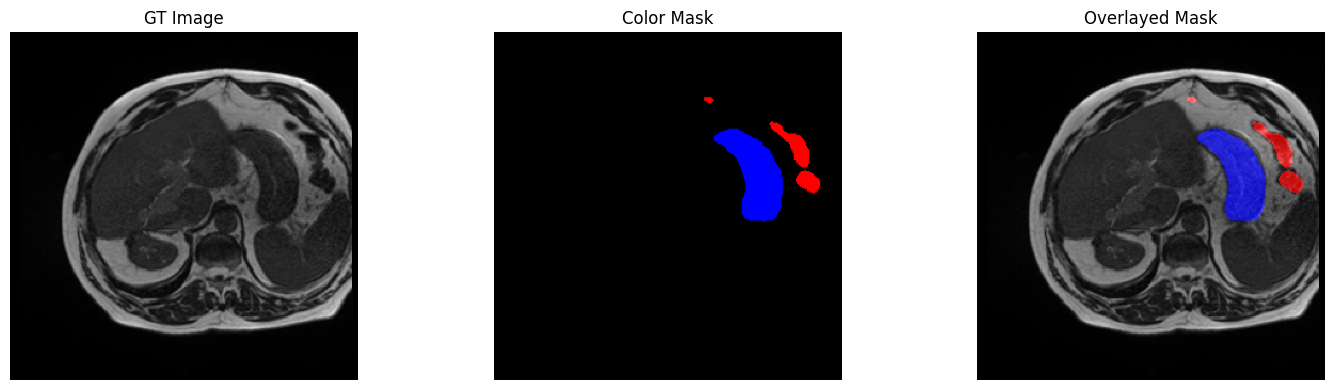

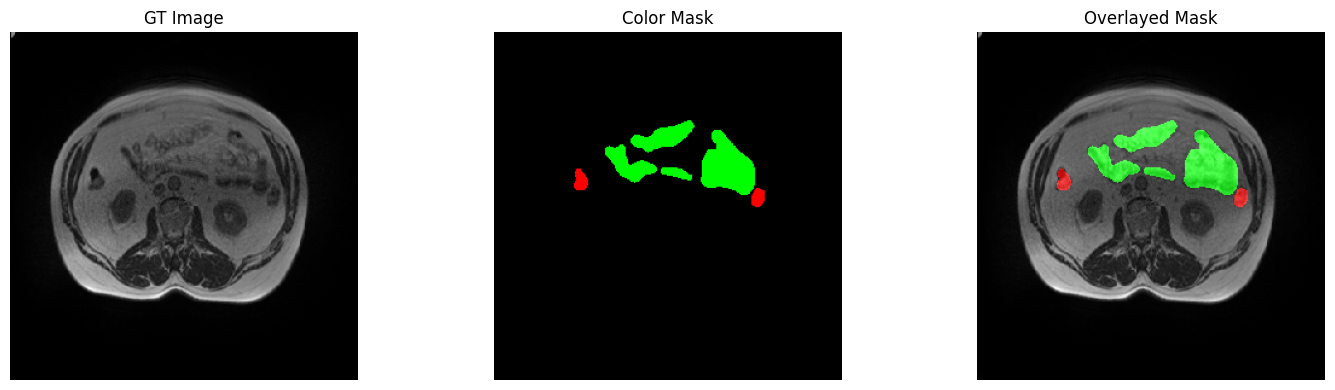

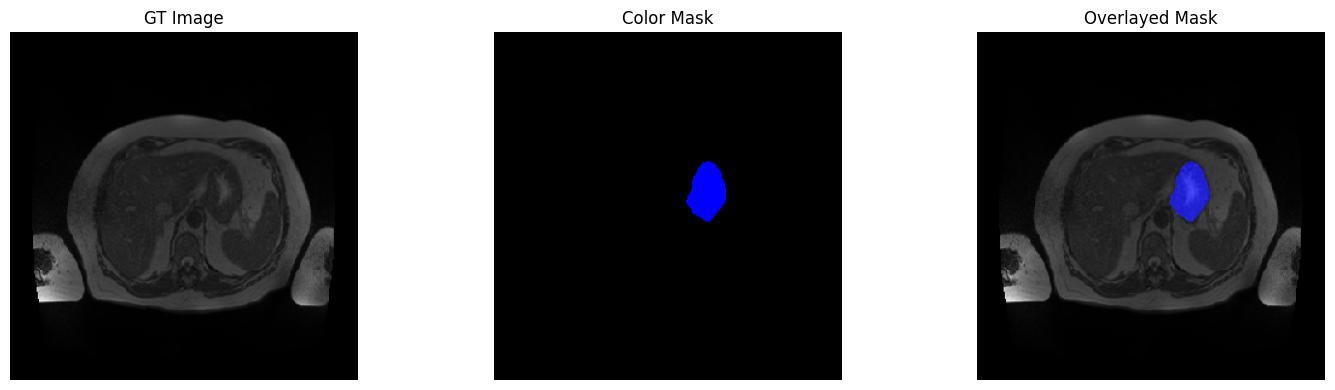

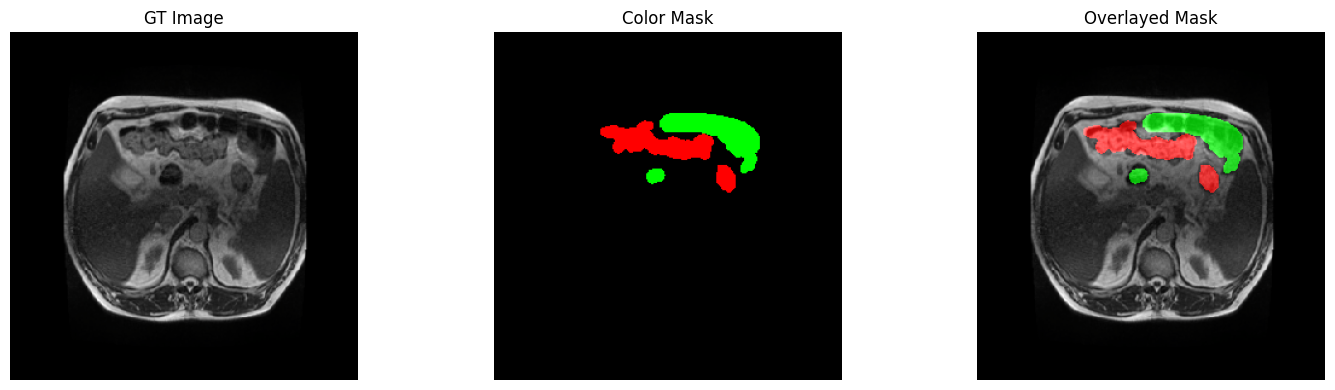

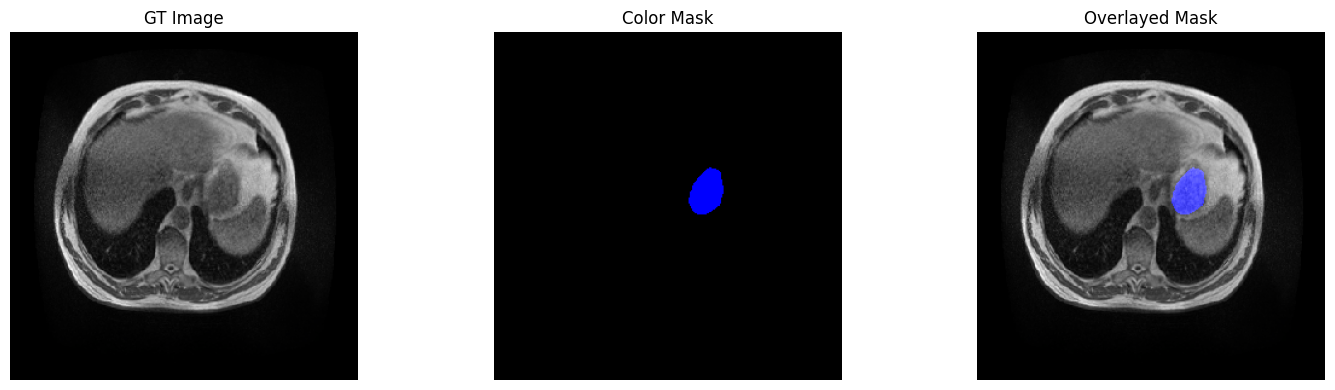

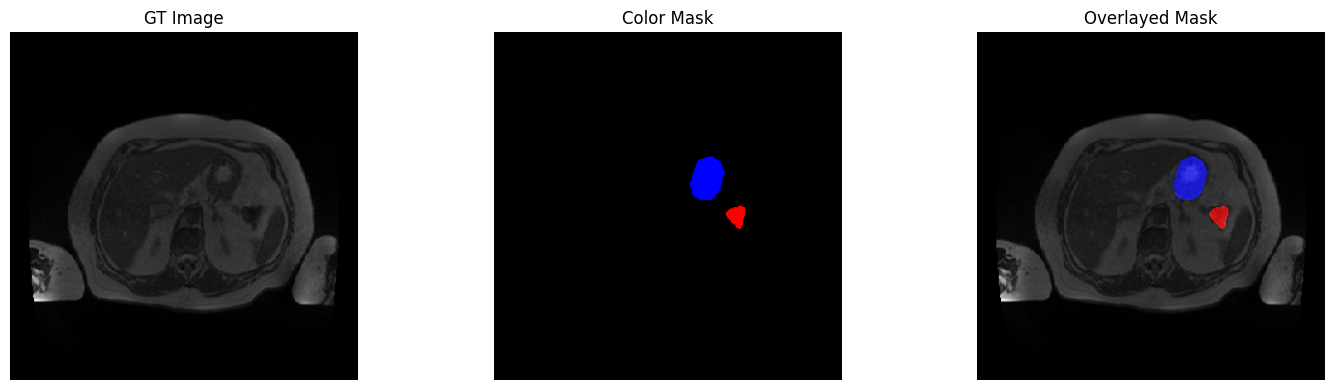

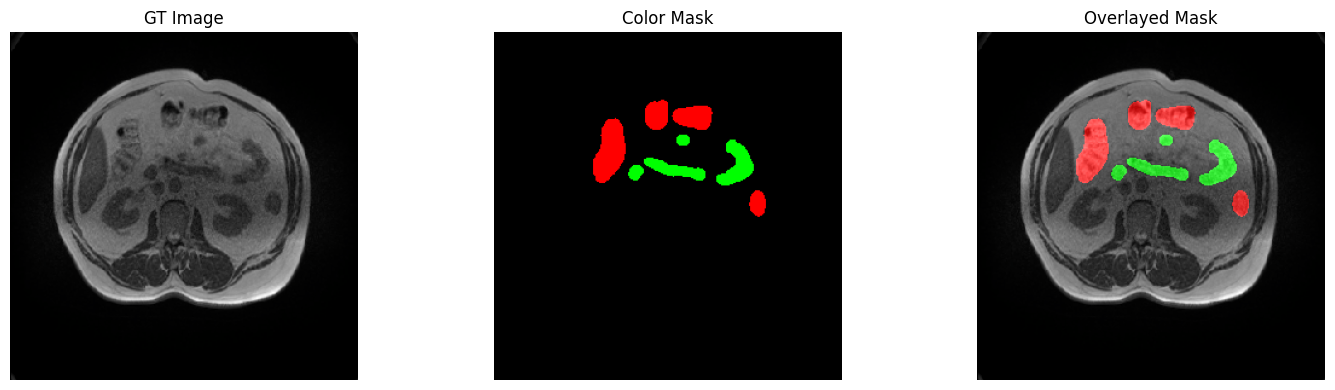

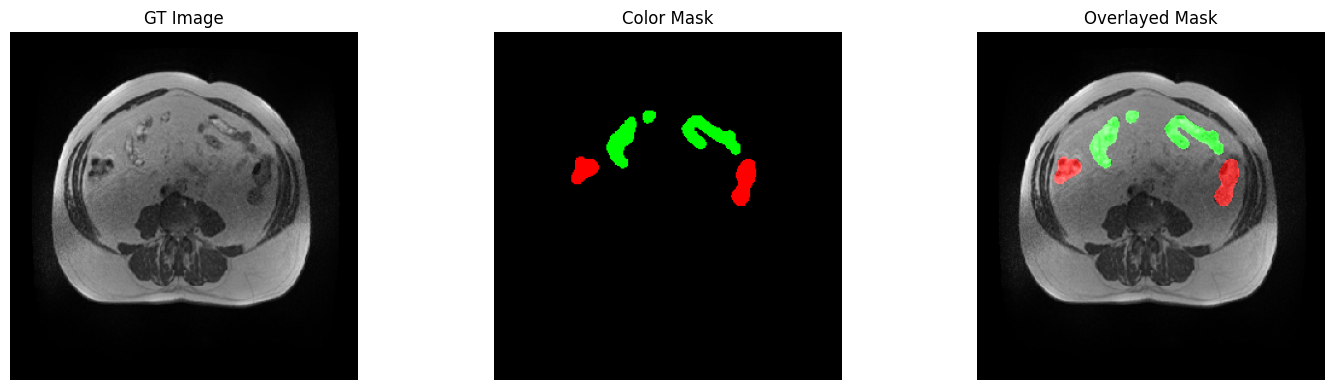

In [318]:
for images, masks in valid_batch:

    images = denormalize(images, mean=DatasetConfig.MEAN, std=DatasetConfig.STD).permute(0, 2, 3, 1).numpy()
    masks  = masks.numpy()
    
    display_image_and_mask(images=images, masks=masks)

    break

In [319]:
def get_model(model_name,num_classes):
    model = SegformerForSemanticSegmentation.from_pretrained(
        model_name,
        num_labels=num_classes,
        ignore_mismatched_sizes=True,
    )
    return model

In [322]:

class LightningTransformer(pl.LightningModule):
    def __init__(self, model_name,num_classes):
        super().__init__()
        self.model = get_model(model_name,num_classes)


    def forward(self,data):
        output = self.model(pixel_values =data,return_dict=True)
        unsampled_logists = F.interpolate(output['logists'],size=data.shape[-2:],mode='bilinear',align_corners=False)
        return unsampled_logists

    def training_step(self, batch, batch_idx):
        inputs, target = batch
        output = self(inputs)
        loss = torch.nn.functional.nll_loss(output, target.view(-1))
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, target = batch
        output = self(inputs)
        loss = torch.nn.functional.nll_loss(output, target.view(-1))
        return loss

    def on_train_epoch_end(self):
        self.log("epoch", self.current_epoch)

    def configure_optimizers(self):
        return torch.optim.SGD(self.model.parameters(), lr=0.1)

In [323]:
class TrainingConfig:
    BATCH_SIZE:      int = 48 # 8
    NUM_EPOCHS:      int = 100
    INIT_LR:       float = 3e-4
    NUM_WORKERS:     int = 0 if platform.system() == "Windows" else os.cpu_count()

    OPTIMIZER_NAME:  str = "AdamW"
    WEIGHT_DECAY:  float = 1e-4
    USE_SCHEDULER:  bool = True # Use learning rate scheduler?
    SCHEDULER:       str = "MultiStepLR" # Name of the scheduler to use.
    MODEL_NAME:str = "nvidia/segformer-b4-finetuned-ade-512-512" 

In [324]:
model = LightningTransformer(
    model_name=TrainingConfig.MODEL_NAME,
    num_classes=DatasetConfig.NUM_CLASSES,
)


data_module = SegmentationDataset(
    num_classes=DatasetConfig.NUM_CLASSES,
    img_size=DatasetConfig.IMAGE_SIZE,
    ds_mean=DatasetConfig.MEAN,
    ds_std=DatasetConfig.STD,
    batch_size=TrainingConfig.BATCH_SIZE,
    num_workers=TrainingConfig.NUM_WORKERS,
    pin_memory=torch.cuda.is_available(),
)




Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b4-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([4, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [325]:
trainer = pl.Trainer(
    accelerator="auto", 
    devices="auto",  
    strategy="auto",  
    max_epochs=TrainingConfig.NUM_EPOCHS,  
    enable_model_summary=True,  
    precision="16-mixed",  
 
)

# Start training
trainer.fit(model, data_module)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\ANING\anaconda3\envs\pytorch\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.42 GiB. GPU 0 has a total capacty of 4.00 GiB of which 316.65 MiB is free. Of the allocated memory 1.97 GiB is allocated by PyTorch, and 67.71 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF